## Top500 Analysis

In this project, I analyze the Top 500 using the framework Apache Spark. 

The data was extracted from https://www.top500.org/lists/top500/2022/06/.

Top500 is a ranking of the most powerful supercomputers. The performances are tested by The Linpack Benchmark, which is based on solve a dense system of linear equations.

The principal caracteristics obtained by Linpack Benchmark of these supercomputers are:

- Rmax [TFlop/s]: Max Linpack performance archivied.

- Rpeak [TFlop/s]: Theorical peak performance.

- TFlop/s: Measure that represent computer performance. By it's initials: Floating Point Operations Per Second.



In [16]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import col

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import squarify

In [17]:
from pyspark.sql import SparkSession

In [18]:
spark = SparkSession.builder.getOrCreate()

In [19]:
tt = spark.read.option('delimiter', ';').option("header", True).csv('./TOP500_202206.csv')

In [20]:
# This kernel change the data type of several columns to then it can be operated.
tt = tt.withColumn('Rmax [TFlop/s]', col('Rmax [TFlop/s]').cast('float'))
tt = tt.withColumn('Rmax [TFlop/s]', col('Rpeak [TFlop/s]').cast('float'))
tt = tt.withColumn('Total Cores', col('Total Cores').cast('int'))
tt = tt.withColumn('Energy Efficiency [GFlops/Watts]', col('Energy Efficiency [GFlops/Watts]').cast('float'))
tt = tt.withColumn('Power (kW)', col('Power (kW)').cast('float'))
tt = tt.withColumn('Processor Speed (MHz)', col('Processor Speed (MHz)').cast('int'))
tt = tt.withColumn('Cores per Socket', col('Cores per Socket').cast('int'))

In [21]:
tt.printSchema()

root
 |-- Rank: string (nullable = true)
 |-- Previous Rank: string (nullable = true)
 |-- First Appearance: string (nullable = true)
 |-- First Rank: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Computer: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Manufacturer: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Total Cores: integer (nullable = true)
 |-- Accelerator/Co-Processor Cores: string (nullable = true)
 |-- Rmax [TFlop/s]: float (nullable = true)
 |-- Rpeak [TFlop/s]: string (nullable = true)
 |-- Nmax: string (nullable = true)
 |-- Nhalf: string (nullable = true)
 |-- HPCG [TFlop/s]: string (nullable = true)
 |-- Power (kW): float (nullable = true)
 |-- Power Source: string (nullable = true)
 |-- Energy Efficiency [GFlops/Watts]: float (nullable = true)
 |-- Memory: string (nullable = true)
 |-- Architecture: string (nullable = true)
 |-- Pr

In [22]:
tt.columns

['Rank',
 'Previous Rank',
 'First Appearance',
 'First Rank',
 'Name',
 'Computer',
 'Site',
 'Manufacturer',
 'Country',
 'Year',
 'Segment',
 'Total Cores',
 'Accelerator/Co-Processor Cores',
 'Rmax [TFlop/s]',
 'Rpeak [TFlop/s]',
 'Nmax',
 'Nhalf',
 'HPCG [TFlop/s]',
 'Power (kW)',
 'Power Source',
 'Energy Efficiency [GFlops/Watts]',
 'Memory',
 'Architecture',
 'Processor',
 'Processor Technology',
 'Processor Speed (MHz)',
 'Operating System',
 'OS Family',
 'Accelerator/Co-Processor',
 'Cores per Socket',
 'Processor Generation',
 'System Model',
 'System Family',
 'Interconnect Family',
 'Interconnect',
 'Continent',
 'Site ID',
 'System ID']

In [23]:
# This variable contains a table that represent the cuantity of supercomputers made by country in the edition of June 2022.
top_countries = tt.groupBy('Country').count().sort('count', ascending=False)
top_countries = top_countries.toPandas()

In [24]:
# This variable contains a table that represent the cuantity of supercomputers made by manufacturer in the edition of June 2022.
top_manufacturers = tt.groupBy('Manufacturer').count().sort('count', ascending=False)
top_manufacturers = top_manufacturers.toPandas()

In [25]:
# This variable contains a table that represent the cuantity of supercomputers made by continent in the edition of June 2022.
top_continent = tt.groupBy('Continent').count().sort('count', ascending=False)
top_continent = top_continent.toPandas()

In [26]:
# This kernel creates a variable to select Rmax and Processor Speed. 
# Then compare the data by means of Linear Regression(Ordinary Least Squares).

# The result of this graph, indicates that the relation between Rmax and Processor Speed is minimal, 
# with a slight tendency to decline when the processor is more powerful.
to_processor_speed_reg = tt.select('Name', 'Rmax [TFlop/s]', 'Processor Speed (MHz)')
to_processor_speed_reg = to_processor_speed_reg.toPandas()


to_processor_speed_reg_graph = px.scatter(to_processor_speed_reg, x=to_processor_speed_reg['Processor Speed (MHz)'],
                                          y=to_processor_speed_reg['Rmax [TFlop/s]'],
                                          trendline = 'ols',
                                          title = 'Computational Performance by Processor Speed'
                                         )

to_processor_speed_reg_graph.show()

In [27]:
# This kernel creates a variable to select Rmax and Total Cores. 
# Then compare the data by means of Linear Regression(Ordinary Least Squares).

# The result of this graph, indicates that the relation between Rmax and Total Cores is positive, 
# a major cuantity of cores, the Rmax should be higher.
to_core_reg = tt.select('Name', 'Rmax [TFlop/s]', 'Total Cores')
to_core_reg = to_core_reg.toPandas()
to_core_reg_graph = px.scatter(to_core_reg,
                               x = to_core_reg['Total Cores'],
                               y = to_core_reg['Rmax [TFlop/s]'],
                               trendline = 'ols',
                               title = 'Computational Performance by Total of Cores'
                              )
to_core_reg_graph.show()

In [28]:
# This kernel creates a variable to select Rmax and Energy Efficiency. 
# Then compare the obtained data by means of Linear Regression(Ordinary Least Squares).

# The result of this graph, indicates that the relation between Rmax and Energy Efficiency is slightly positive, 
# The higher the Energy Efficiency, the higher the Rmax.
to_efficiency_reg = tt.select('Name', 'Rmax [TFlop/s]', 'Energy Efficiency [GFlops/Watts]')
to_efficiency_reg = to_efficiency_reg.toPandas()
to_efficiency_reg_graph = px.scatter(to_efficiency_reg,
                                     x = to_efficiency_reg['Energy Efficiency [GFlops/Watts]'], 
                                     y = to_efficiency_reg['Rmax [TFlop/s]'],
                                     trendline = 'ols',
                                     title = 'Computational Performance by Energy Efficiency'
                                    )
to_efficiency_reg_graph.show()

In [29]:
# This kernel creates a variable to select Rmax and Power supplied. 
# Then compare the obtained data by means of Linear Regression(Ordinary Least Squares).

# The result of this graph, indicates that the relation between Rmax and Processor Speed is positive, 
# The more Power supplied, the higher the Rmax.
powerkw_reg = tt.select('Name', 'Rmax [TFlop/s]', 'Power (kW)', 'Architecture')
powerkw_reg = powerkw_reg.toPandas()

powerkw_reg_graph = px.scatter(powerkw_reg,
                               x = powerkw_reg['Power (kW)'],
                               y = powerkw_reg['Rmax [TFlop/s]'],
                               color = 'Architecture'
                               title = 'Supercomputer Performance by Power and Architecture',
                               trendline = 'ols',
                               color_discrete_sequence = ['#2A86DE', '#E05E2D']
                              )
powerkw_reg_graph.show()

### The next kernels calculates the most used tecnologies to build up the supercomputers

In [30]:
most_used_speed_processor = tt.groupBy('Processor Speed (MHz)').count().sort('count', ascending=False)
most_used_speed_processor = most_used_speed_processor.toPandas()
most_used_speed_processor = most_used_speed_processor.rename(columns={"count":"Quantity"})

most_used_speed_processor_graph = px.bar(most_used_speed_processor,
                                       x = most_used_speed_processor['Processor Speed (MHz)'],
                                       y = most_used_speed_processor['Quantity'],
                                       title = 'Quantity of Supercomputers by Processor Speed'
                                      )
most_used_speed_processor_graph.show()

In [31]:
avg_Rmax_architecture = tt.groupBy('Architecture').avg('Rmax [TFlop/s]').orderBy('avg(Rmax [TFlop/s])')
avg_Rmax_architecture = avg_Rmax_architecture.toPandas()
avg_Rmax_architecture

,Architecture,avg(Rmax [TFlop/s])
0,Cluster,8353.072693
1,MPP,60743.374363


(0.0, 300.0, 0.0, 350.0)

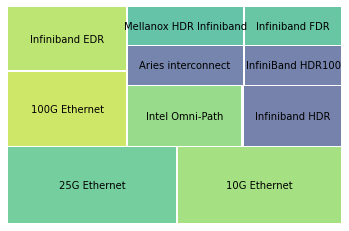

In [32]:
interconnect_types_used = tt.groupBy('Interconnect').count().sort('count', ascending=False)
interconnect_types_used = interconnect_types_used.toPandas()
first10 = interconnect_types_used.head(10)
f = squarify.plot(
    sizes = first10['count'],
    label = first10['Interconnect'],
    alpha=.7,
    pad = True,
    norm_x = 300,
    norm_y = 350
)

plt.axis("off")

(0.0, 300.0, 0.0, 350.0)

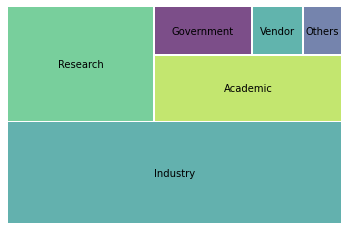

In [33]:
segment_type = tt.groupBy('Segment').count().sort('count', ascending=False)
segment_type = segment_type.toPandas()
squarify.plot(
    sizes = segment_type['count'],
    label = segment_type['Segment'],
    alpha=.7,
    pad = True,
    norm_x = 300,
    norm_y = 350
)

plt.axis("off")